In [1]:
import json
from pathlib import Path

import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import patheffects as path_effects

import geopandas as gpd
import numpy as np

mpl.rcParams['hatch.linewidth'] = 2.0

In [2]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

In [3]:
def load_zone_subset(shapes):
    feature_subset = []
    desired_props = ['Asia/Urumqi', 'Asia/Shanghai']

    # TODO: Glom it!
    for val in shapes['features']:
        if not desired_props:
            break

        props = val.get('properties')
        if props is None:
            continue

        tzid = props.get('tzid')
        if tzid in desired_props:
            feature_subset.append(val)
            desired_props.remove(tzid)

    shape_subset = {'type': 'FeatureCollection', 'features': feature_subset}
    
    return shape_subset

In [4]:
zone_subsets = Path('zone_subset.geojson')
full_zones = Path('timezones.geojson.zip')
zonefile_download_loc = ('https://github.com/evansiroky/timezone-boundary-builder/releases/download/' +
                        '2018d/timezones.geojson.zip')

if zone_subsets.exists():
    with open(zone_subsets) as f:
        shape_subset = json.load(f)
else:
    if not full_zones.exists():
        import requests
        import shutil

        # TODO: Add logging
        with requests.get(zonefile_download_loc, stream=True) as r:
            with open(full_zones, 'wb') as f:
                shutil.copyfileobj(r.raw, f)

    from zipfile import ZipFile

    with ZipFile(full_zones, mode='r') as zipf:
        with zipf.open('dist/combined.json') as geoj:
            # Open the GeoJSON to get the data we want
            shapes = json.load(geoj)
    
    shape_subset = load_zone_subset(shapes)
    
    with open(zone_subsets, 'w') as f:
        json.dump(obj=shape_subset, fp=f)

In [5]:
# Get all countries with centroids within 100 units of china's centroid
china_centroid = world.loc[world['name'] == 'China'].iloc[0].geometry
def within_box():
    return np.linalg.norm([c.x - china_centroid.x, c.y - china_centroid.y])

near_china = world.loc[world['geometry'].centroid.map(china_centroid.distance) < 8]

In [6]:
tzdf = gpd.GeoDataFrame.from_features(shape_subset)
tzdf = tzdf.set_index('tzid')

In [7]:
def get_label_loc(gs):
    loc = gs['geometry'].representative_point()
    return loc.x, loc.y

In [8]:
# Figure configuration
china_color = '#9b59b6'
urumqi_color = "#34495e"
urumqi_color = "#e74c3c"
urumqi_color = '#feb308'
map_face_color = '#95a5a6'
map_edge_color = '#3d5c5c'

fig_size = (8, 5)

def merge_kwargs(default_kwargs, **kwargs):
    kw = default_kwargs.copy()
    kw.update(kwargs)
    
    return kw

# Base map
base_map_kwargs = dict(
    linewidth=1,
    edgecolor='#3d5c5c',
    color='#95a5a6'
)
def plot_base_map(ax, **kwargs):
    near_china.plot(ax=ax, **merge_kwargs(base_map_kwargs, **kwargs))
    
# Base zone
zone_line_kwargs = dict(
    linestyle='--',
    edgecolor='k',
    linewidth=2
)

# Labels
label_opts = dict(fontsize=20, weight='bold', color='white',
                  ha='center', va='center')
label_path_effects = [path_effects.Stroke(linewidth=3, foreground='black'),
                      path_effects.Normal()]

def annotate(*args, **kwargs):
    text = plt.annotate(*args, **merge_kwargs(label_opts, **kwargs))
    text.set_path_effects(label_path_effects)
    
    
# Plot cleanup function
def plot_cleanup(ax=None):
    plt.xticks([])
    plt.yticks([])
    plt.gca().axis('off')
    
    plt.tight_layout()
    plt.show()
    

# Figure saving
fig_kwargs = dict(frameon=False)
def new_fig(*args, **kwargs):
    fig = plt.figure(*args, **merge_kwargs(fig_kwargs, **kwargs))
    
    fig.patch.set_alpha(0)
    fig.patch.set_facecolor('none')
    #fig.patch.set_visible(False)

    return fig

fig_save_options = dict(
    dpi=180,
    transparent=True
)

def save_fig(fig, name, **kwargs):
    fig.savefig(name, **merge_kwargs(fig_save_options, **kwargs))

In [9]:
# Plot data
shanghai_label = 'UTC+8'
urumqi_label = 'UTC+6'

urumqi_s = gpd.GeoSeries(tzdf.loc['Asia/Urumqi'])
china_s = gpd.GeoSeries(world.loc[world['name'] == 'China'].iloc[0])
shanghai_s = gpd.GeoSeries(tzdf.loc['Asia/Shanghai'])


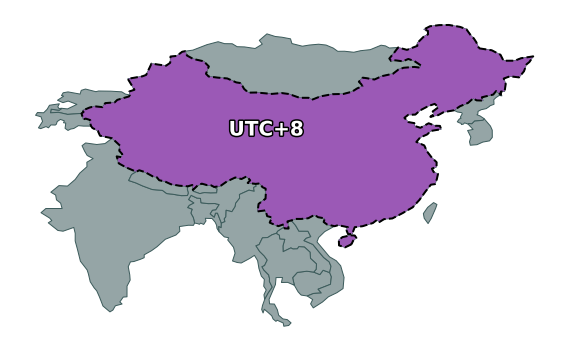

In [10]:
# Plot just-china figure
fig = new_fig(figsize=fig_size)

# Make the plot background
ax = fig.gca()
plot_base_map(ax=ax)


# Plot the Chinese time zone
china_s.plot(ax=ax, color=china_color, **zone_line_kwargs)
annotate(s=shanghai_label, xy=get_label_loc(china_s))

plot_cleanup()
save_fig(fig, 'images/china_shanghai.png')

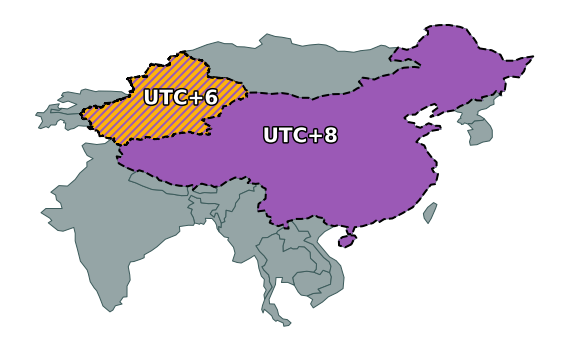

In [11]:
# Plot overlay figure
fig = new_fig(figsize=fig_size);

# Make the plots
ax = plt.gca()
plot_base_map(ax=ax)

china_s.plot(ax=ax, color=china_color, linewidth=2, linestyle='--', edgecolor='k')
annotate(s=shanghai_label, xy=get_label_loc(shanghai_s))

# Plot Urumqi overlay
urumqi_s.plot(ax=ax, color=urumqi_color, edgecolor=china_color,
              linewidth=0,
              hatch=r'///')

# Plot Urumqi outline
urumqi_s.plot(ax=ax, color='none', **zone_line_kwargs)
annotate(s=urumqi_label, xy=get_label_loc(urumqi_s))



plot_cleanup()
save_fig(fig, 'images/china_overlay.png');

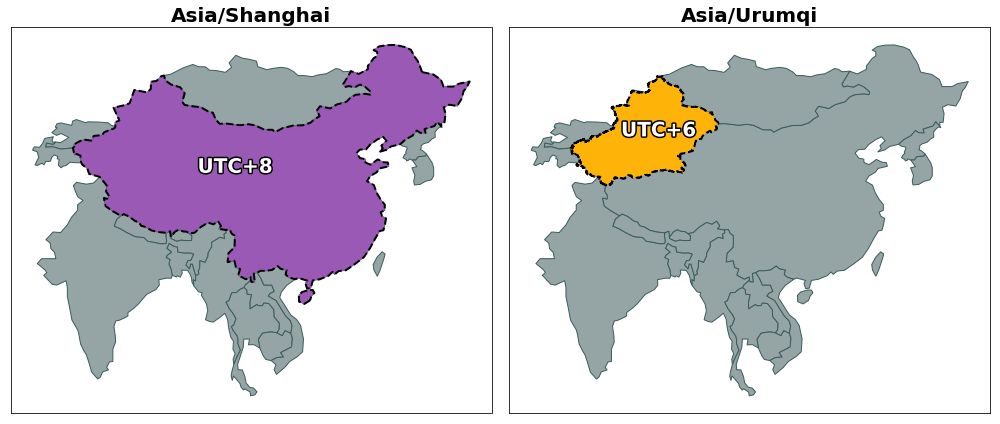

In [12]:
fig = new_fig(figsize=(14, 6))

tzsd = {}
tzsd['Asia/Shanghai'] = (shanghai_label,
                         china_color,
                         gpd.GeoSeries(world.loc[world['name'] == 'China'].iloc[0]))
tzsd['Asia/Urumqi'] = (urumqi_label,
                       urumqi_color,
                       gpd.GeoSeries(tzdf.loc['Asia/Urumqi']))

for i, (tzid, (label, color, tzs)) in enumerate(tzsd.items()):
    plt.subplot(1, 2, i + 1)
    ax = plt.gca()
    plot_base_map(ax=ax)
    
    tzs.plot(ax=ax, color=color, **zone_line_kwargs)
    
    plt.xticks([])
    plt.yticks([])
    plt.title(tzid, fontsize=20, weight='bold')
    
    annotate(s=label, xy=get_label_loc(tzs))


plt.tight_layout()
plt.show()
save_fig(fig, 'images/china_side_by_side.png');